## Energy Resolution of Germanium detectors

Eugenia Boccanera 2109310  
Lucrezia Rossi 2122164

_testo del progetto_  

NaI and Germanium detectors have wide fields of application for γ- and X-ray spectrometry thanks to their good energy resolution. The energy resolution of these detectors is defined as the width of the detected energy spectra peaks (FWHM); it depends on  
    - the statistics of the charge creation process  
    - the properties of the detector, and primarly its charge cllelction efficency   
    - the electronics noise  

The resolution can be expressed as the suquared sum of two terms:   
$$FWHM = \sqrt{(w_d)^2 + (w_e)^2}$$   
where the first term depends on teh detector properties as:  
$w_d = 2 * \sqrt{(2 * \log(2)) * F * E_{\gamma} * w}$   
with $F$ the _Fano factor_,  
$E_{\gamma}$  the energy of the photon deposited energy(?)  
$w$ the electron hole-porduced energy threshold in germanium (w ~ 3eV).

The $w_e$ term in eq.1 is connected with the readout electronics and depends on the detector capacitance, the size of the detector and the bias voltage.

The following plot shows an uncalibrated energy spectrum collected with a Germanium detector
irradiated by a combination of three sources: 241Am, 60Co and 137Cs[2].

According to [2], the source nuclides emit the following photons:
Nuclide 241Am 137Cs 60Co
Photon energy (keV) 59.54 661.66 1173.24 1332.51
and these are the first four peaks (starting from the left side) visible in the figure. Similar spectra have
been collected with other gamma sources (i.e. Th-228).

Detailed Steps

Per portare a termine questo progetto, seguirai una serie di passi per studiare la risoluzione energetica e le incertezze dei rivelatori di Germanio (Ge) e NaI (Sodio Ioduro) utilizzando metodi bayesiani.

##### 1. Understand the Data and Model

The energy resolution (FWHM) of the Germanium detectors is given by:  
$$FWHM = \sqrt{(w_d)^2 + (w_e)^2}$$


with  
$w_d = 2 * \sqrt{(2 * \log(2)) * F * E_{\gamma} * w}$  


    ​

    Here, F is the Fano factor, $E_{\gamma}$​ is the energy of the photon, and w is the electron-hole production energy threshold in Germanium (approximately 3 eV).

    You need to determine w_d_​ and w_e_​ for your data.

##### 2. Define the Model for Fitting Peaks

Identify the function you will use to fit the peaks. A common choice for spectral peaks is the Gaussian function.
Define the full model incorporating the equation for FWHM and how it relates to the observed data.

Use a Gaussian function to model the peaks in the energy spectra:
$$f(E)=A * exp⁡(−\frac{(E−μ)^2}{2σ^2})$$
    
where μ is the peak center, σ is the standard deviation related to FWHM by $FWHM = 2 * \sqrt{2 * \log{2}} * \sigma$, and A is the amplitude.

##### 3. Set Up Bayesian Inference

ecc


### Theory Behind Bayesian Inference

Bayesian inference combines prior knowledge with observed data to update the probability of a hypothesis. The steps are:

- Prior Distribution: Represents your initial beliefs about the parameters before seeing the data.   
- Likelihood: Represents the probability of the observed data given the parameters.  
- Posterior Distribution: Updated beliefs about the parameters after considering the data, obtained via Bayes' theorem:  
    $P(θ∣data) ∝ P(data∣θ)P(θ)$


MCMC methods, such as the Metropolis-Hastings algorithm, are used to sample from the posterior distribution when it cannot be computed analytically.

Metropolis-Hastings: Proposes new parameter values and accepts them based on an acceptance criterion.


## 1. 
### Using statistical methods similar to that presented during the course, infere the FWHM of each γ peak for all available γ sources

### a. Load the required libraries

In [2]:
# Load the libraries
library(rstan)
library(ggplot2)
library(bayesplot)

library(dplyr)
library(nlstools)
library(pracma)

library(gridExtra)

# Configure rstan
rstan_options(auto_write = TRUE)
options(mc.cores = parallel::detectCores())


### b. Load the data

I dati nei files rappresentano un tipico spettro energetico ottenuto da un rivelatore, in questo caso presumibilmente un rivelatore di germanio, dopo essere stato irradiato da una sorgente contenente Cesio-137 (Cs-137) (es). Ogni riga del file contiene due valori:

    Il primo valore rappresenta il canale del rivelatore, che è essenzialmente l'indice o la posizione del dato nel file.  
    Il secondo valore rappresenta il numero di conteggi (o eventi) registrati in quel canale durante la misura dell'energia.  

Canale del rivelatore:

    Ogni rivelatore di energia (come un rivelatore di germanio) divide l'intervallo di energia che può misurare in canali discreti. Ogni canale corrisponde a una determinata gamma di energia che il rivelatore è in grado di rilevare.

Conteggi:

    I conteggi registrati rappresentano il numero di volte che il rivelatore ha rilevato un evento energetico (un fotone gamma, nel caso di un rivelatore di germanio) in quel particolare canale durante l'esperimento.



In [32]:
# Load the data
gr11_co60 <- read.table("gr11_co60.txt", header = FALSE)
gr11_cs137 <- read.table("gr11_cs137.txt", header = FALSE)
gr11_na22 <- read.table("gr11_na22.txt", header = FALSE)
IC48A_AmCsCo <- read.table("IC48A_AmCsCo.txt", header = FALSE)
IC48A_Th <- read.table("IC48A_Th.txt", header = FALSE)

# Assign column names
colnames(gr11_co60) <- c("Channel", "Count")
colnames(gr11_cs137) <- c("Channel", "Count")
colnames(gr11_na22) <- c("Channel", "Count")
colnames(IC48A_AmCsCo) <- c("Channel", "Count")
colnames(IC48A_Th) <- c("Channel", "Count")

# Drop the rows with Count <= 0
gr11_co60 <- gr11_co60[gr11_co60$Count > 0, ]
gr11_cs137 <- gr11_cs137[gr11_cs137$Count > 0, ]
gr11_na22 <- gr11_na22[gr11_na22$Count > 0, ]
IC48A_AmCsCo <- IC48A_AmCsCo[IC48A_AmCsCo$Count > 0, ]
IC48A_Th <- IC48A_Th[IC48A_Th$Count >0, ]

# Add the column log_Count
gr11_co60$log_Count <- log(gr11_co60$Count)
gr11_cs137$log_Count <- log(gr11_cs137$Count)
gr11_na22$log_Count <- log(gr11_na22$Count)
IC48A_AmCsCo$log_Count <- log(IC48A_AmCsCo$Count)
IC48A_Th$log_Count <- log(IC48A_Th$Count)


### c. Inspect the Data - Plot the Spectra

Ogni picco nello spettro rappresenta un'energia specifica dei fotoni gamma emessi dalle sorgenti radioattive, come Co-60, Cs-137, Na-22, AmCsCo, o Th. L'analisi di questi spettri permette di identificare e caratterizzare le sorgenti radioattive presenti, valutare la risoluzione energetica del rivelatore e studiare altre proprietà del rivelatore e delle sorgenti.

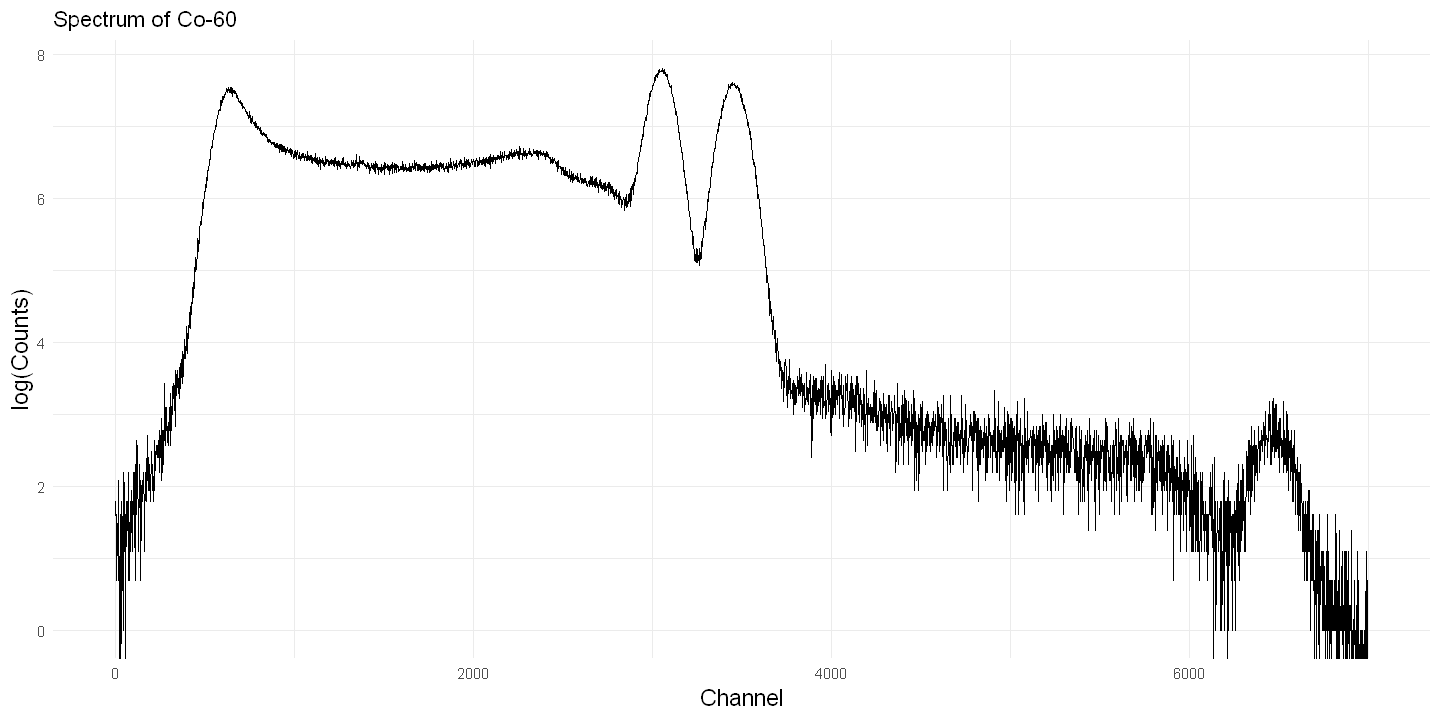

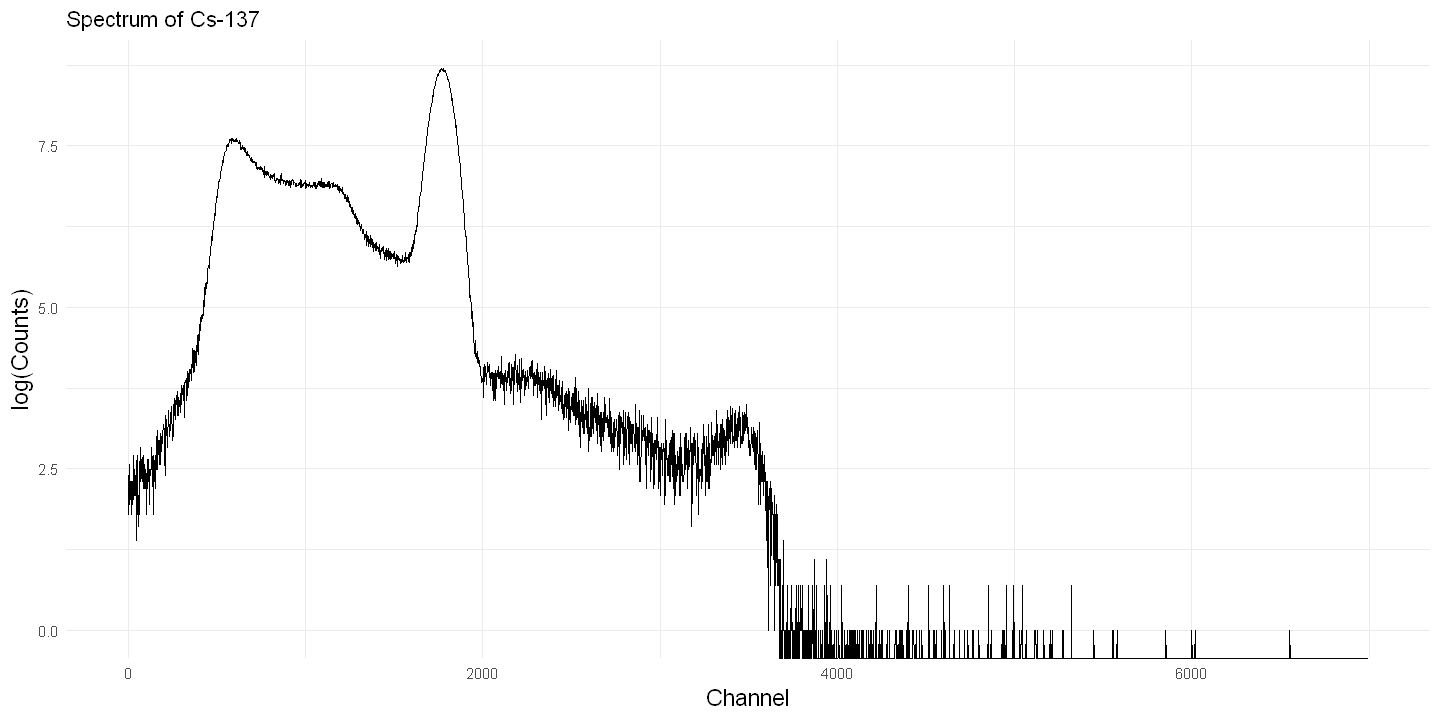

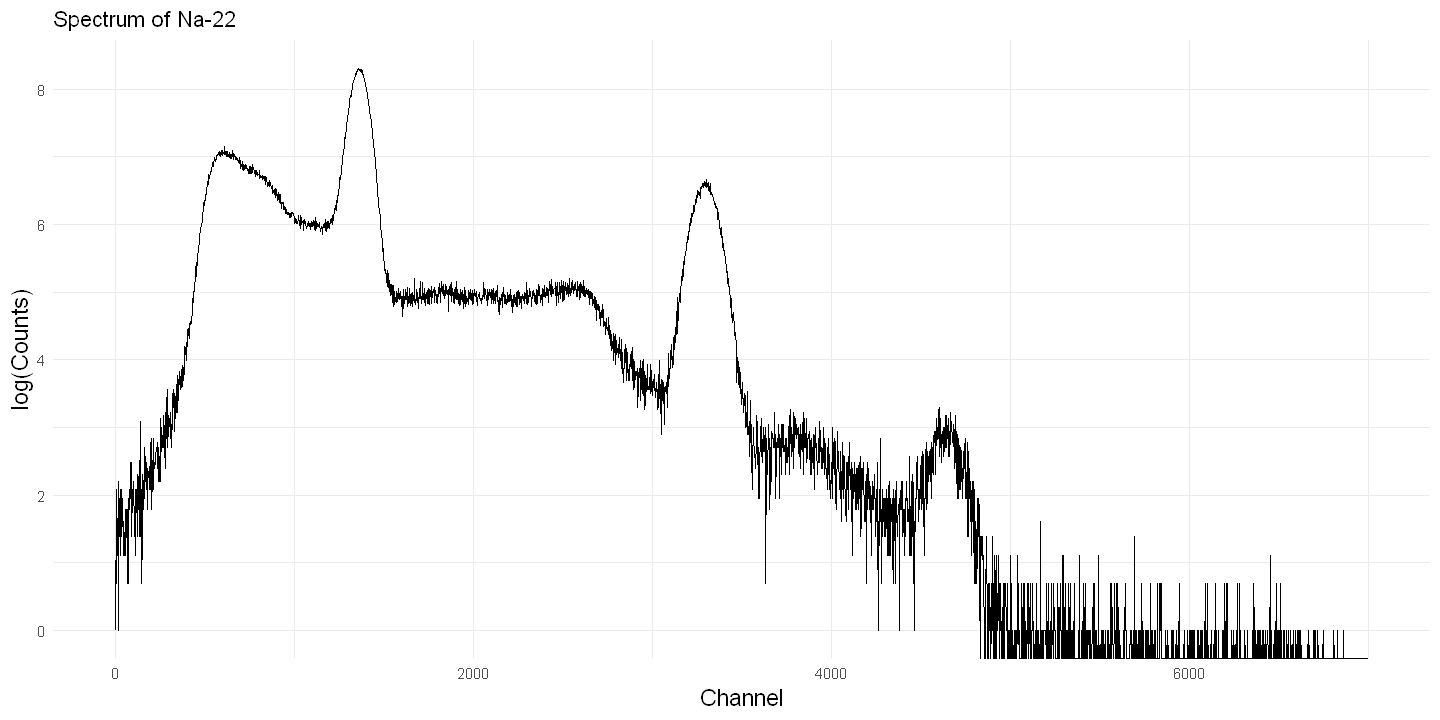

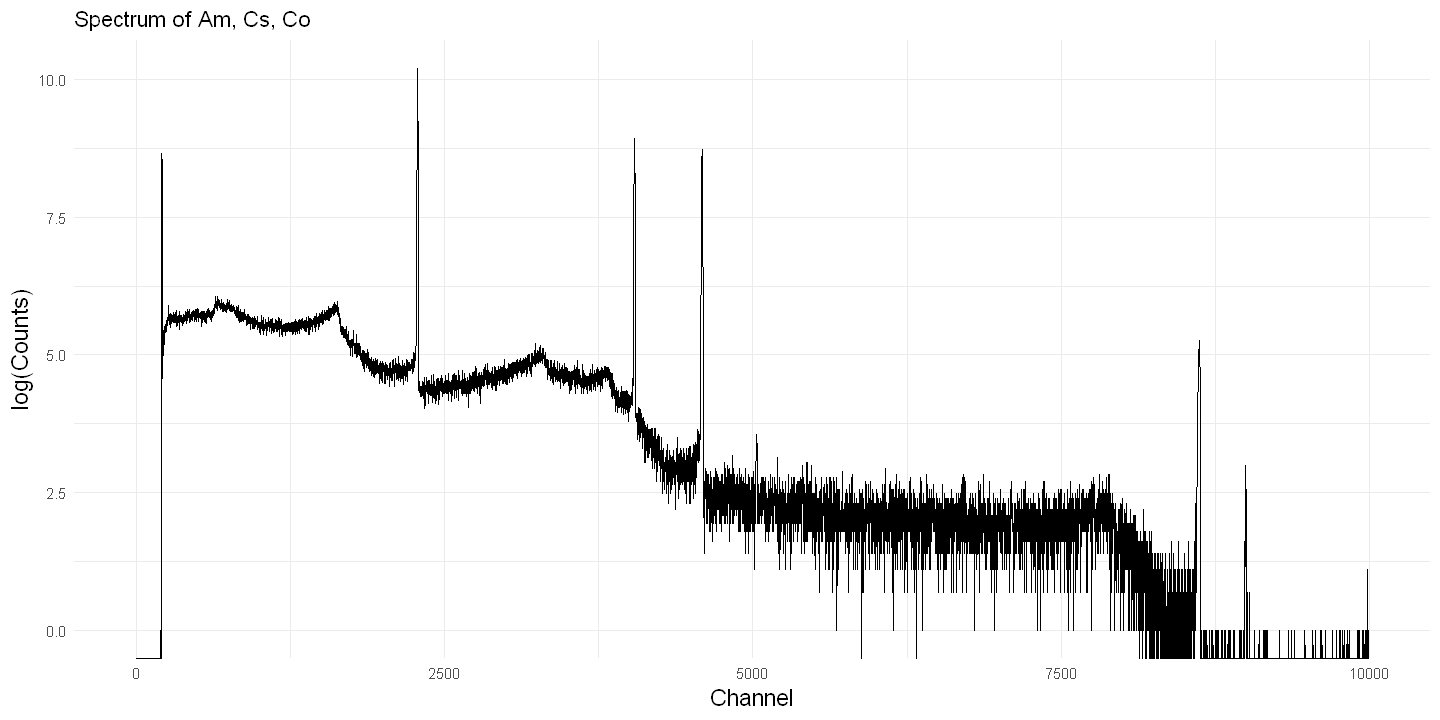

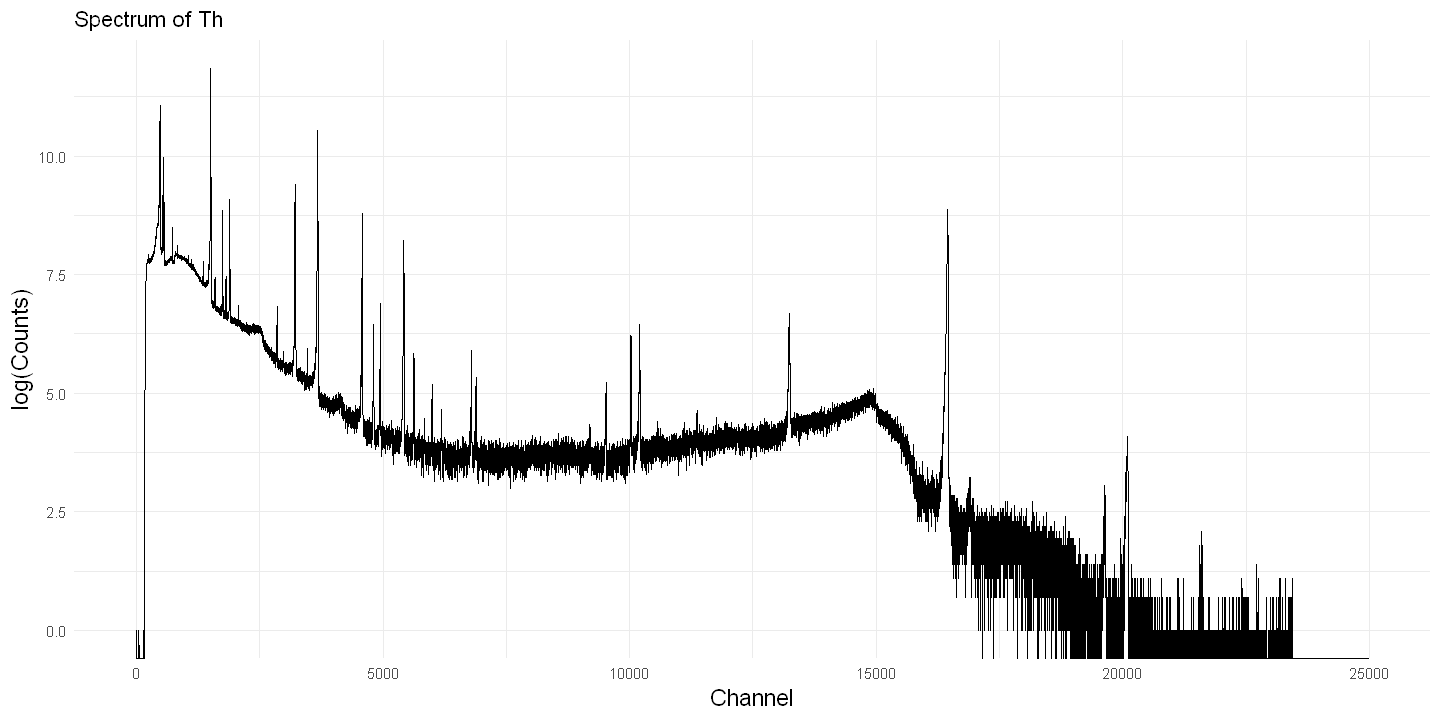

In [6]:
# Plot function
options(repr.plot.width = 12, repr.plot.height = 6)
plot_spectrum <- function(data, title) {
  ggplot(data, aes(x = Channel, y = log_Count)) +
    geom_line(col='black', lwd=0.2, na.rm = TRUE) +
    ggtitle(title) +
    xlab("Channel") +
    ylab("log(Counts)") +
    theme_minimal() +
    #xlim(1, 6000)  +
    theme(axis.title = element_text(size = 14))
}

# Plot each spectrum
plot_spectrum(gr11_co60, "Spectrum of Co-60")
plot_spectrum(gr11_cs137, "Spectrum of Cs-137")
plot_spectrum(gr11_na22, "Spectrum of Na-22")
plot_spectrum(IC48A_AmCsCo, "Spectrum of Am, Cs, Co")
plot_spectrum(IC48A_Th, "Spectrum of Th")


### d. Find Peaks and Infer FWHM

La funzione movavg dalla libreria pracma viene utilizzata per applicare una media mobile semplice ai valori nella colonna Value. La media mobile aiuta a ridurre il rumore nei dati, facilitando l'identificazione dei picchi principali.
La media mobile viene calcolata su una finestra di dimensione window_size (5 per default).
I valori levigati vengono salvati in smoothed_values

I puntini rossi che vengono plottati corrispondono ai picchi effettivamente trovati dalla funzione find_local_peaks_around_x. Questa funzione trova i massimi locali nella colonna log_Count dei dati intorno ai valori di x_values che hai specificato.

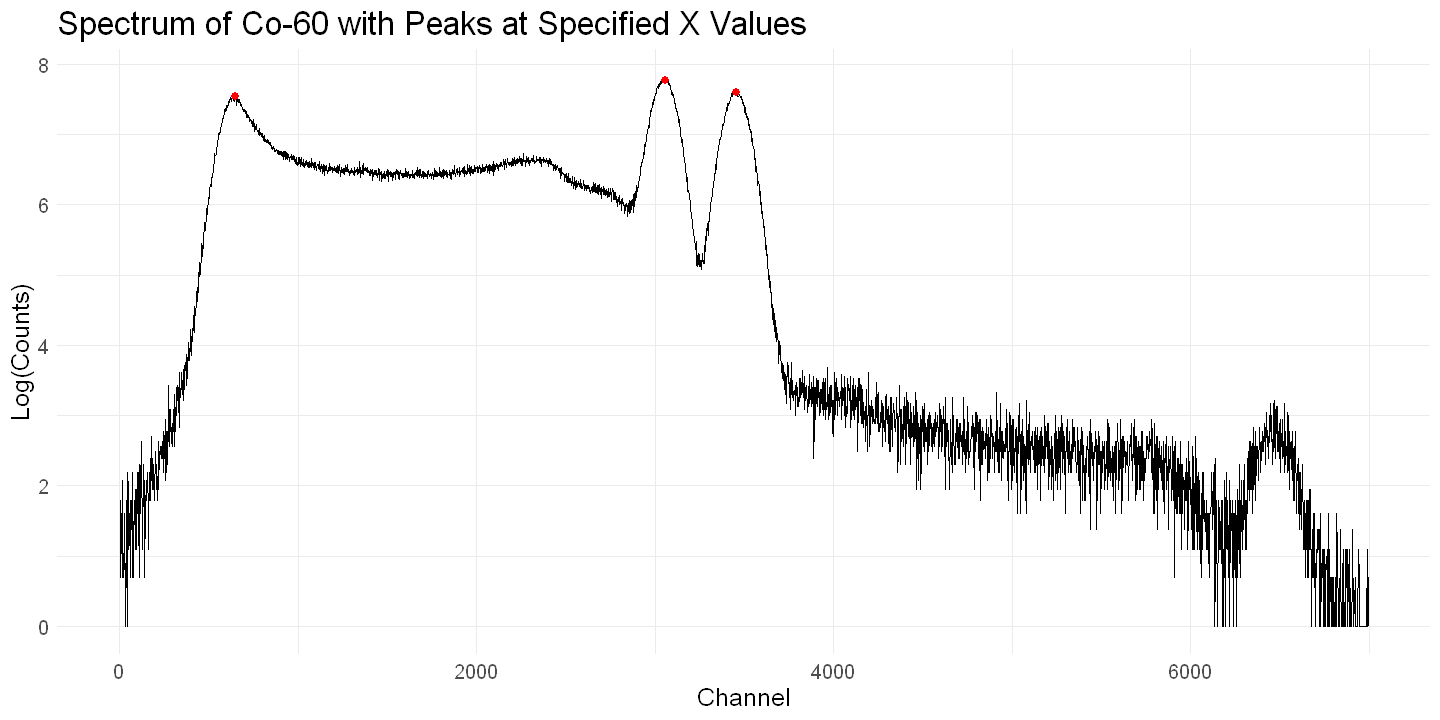

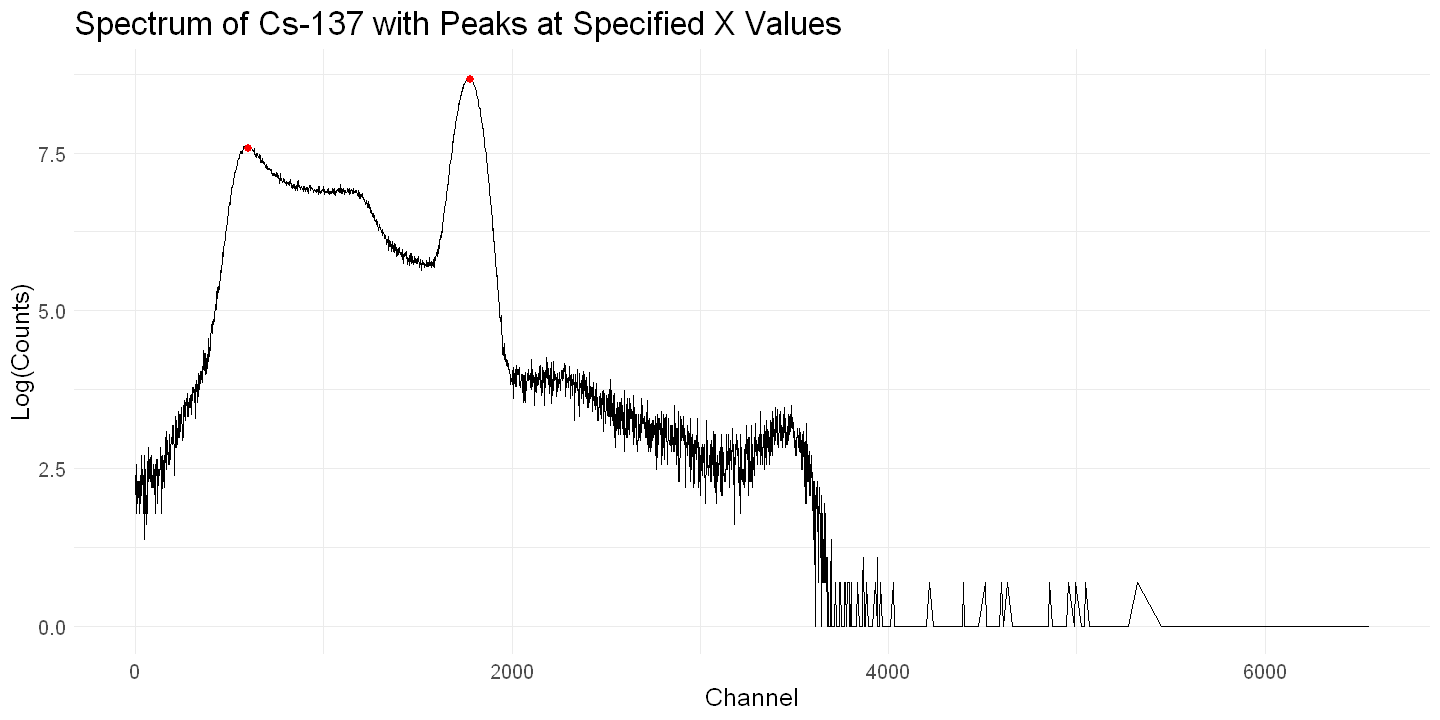

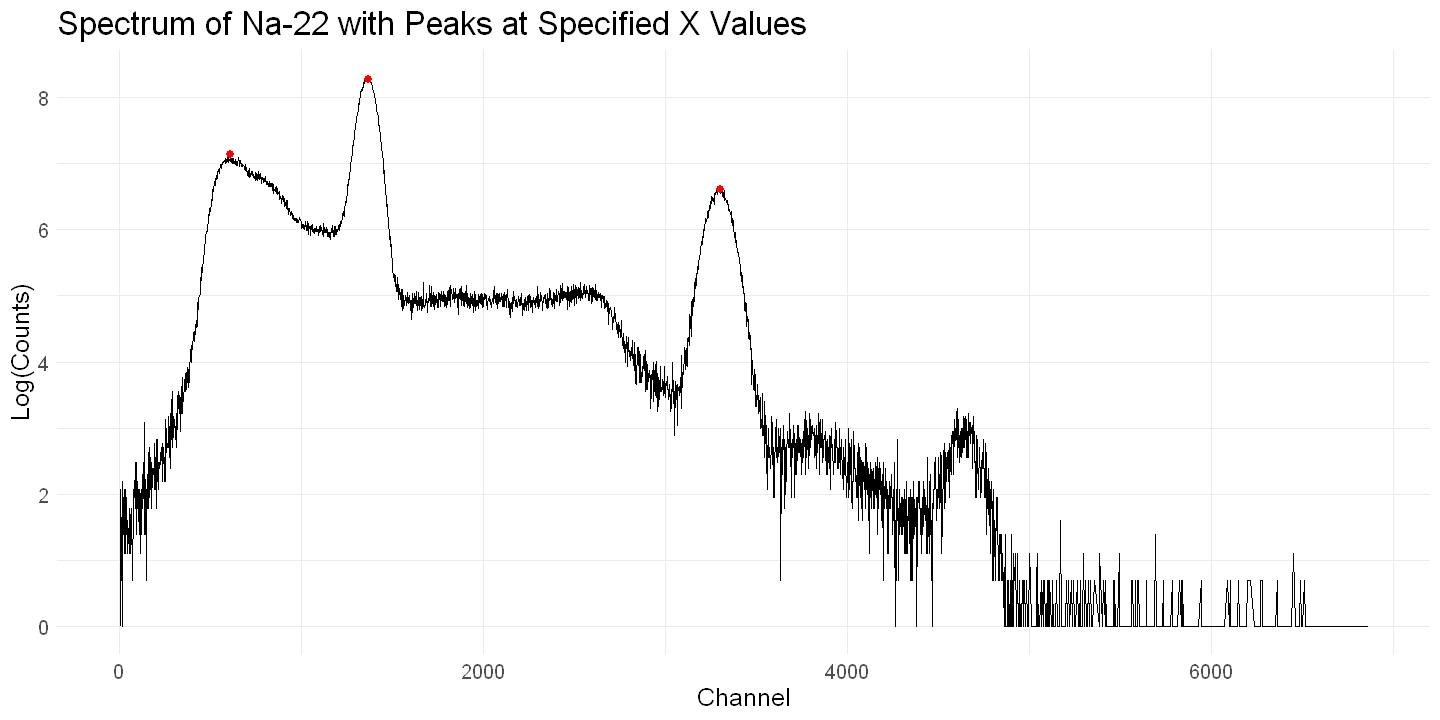

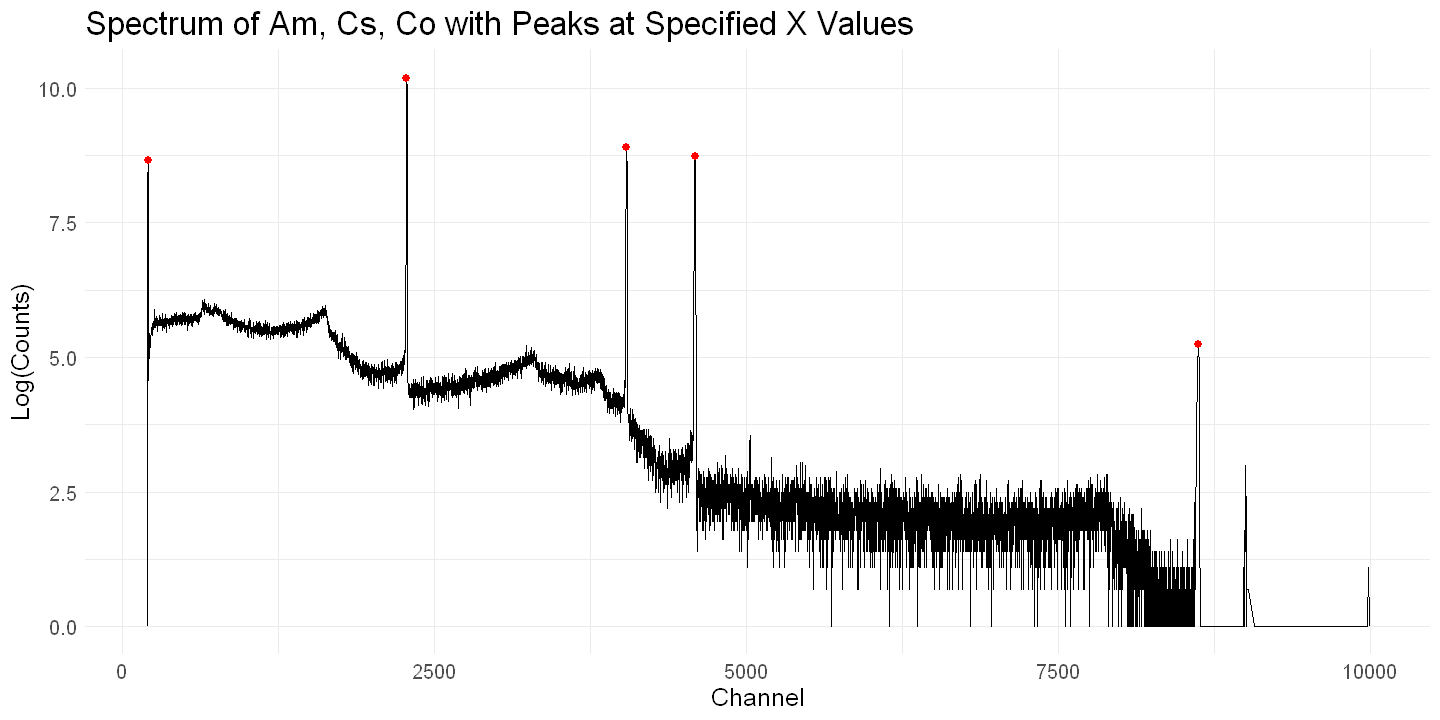

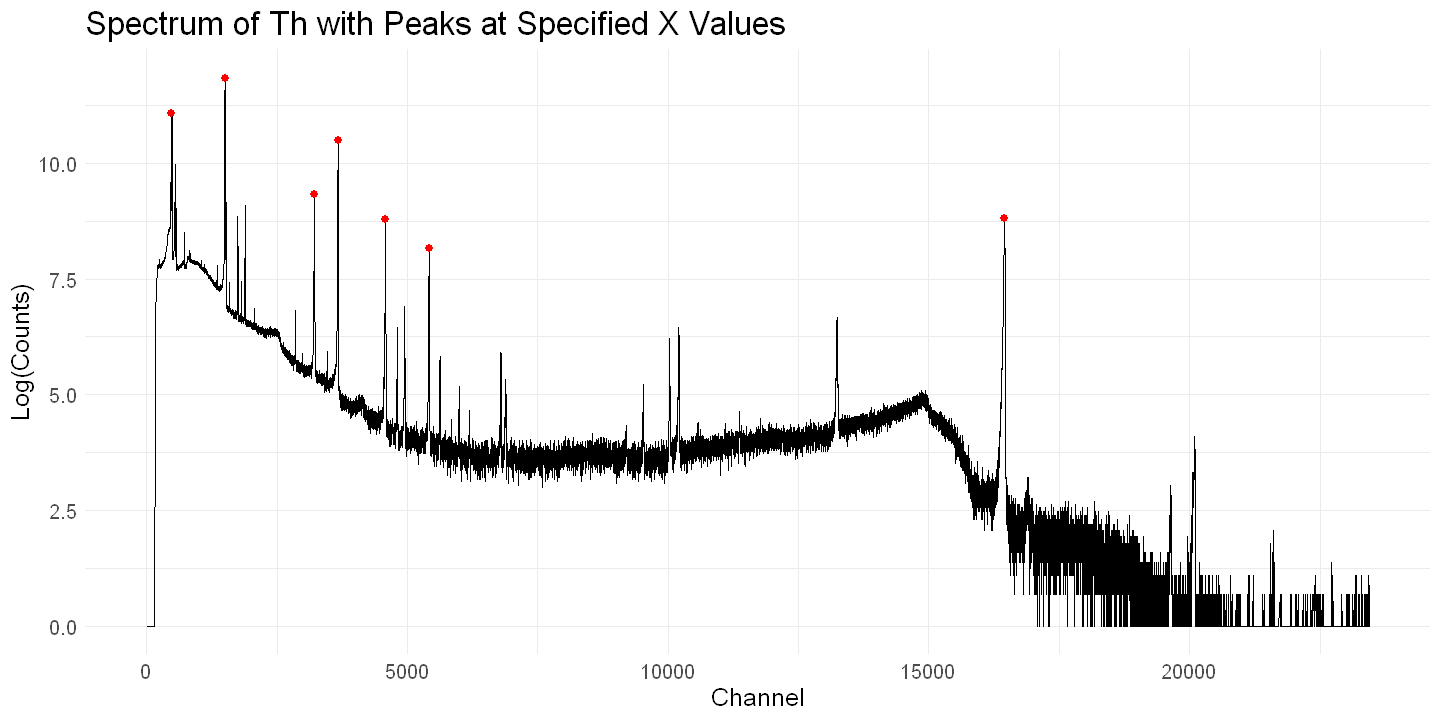

In [72]:
# Function to find indices of values closest to specified x values
find_indices_around_x <- function(data, x_values) {
  indices <- numeric(0)
  for (x_val in x_values) {
    index <- which.min(abs(data$Channel - x_val))
    indices <- c(indices, index)
  }
  return(indices)
}


# Function to find and print peaks around specified x values
find_and_plot_peaks_around_x <- function(data, title, x_values) {
  indices <- find_indices_around_x(data, x_values)
  
  # Get peak positions
  peak_positions <- data$Channel[indices]
  
  # Plot the data with red points at specified x values
  ggplot(data, aes(x = Channel, y = log_Count)) +
    geom_line() +
    geom_point(data = data[indices, ], aes(x = Channel, y = log_Count), color = "red", size = 2) +
    ggtitle(title) +
    xlab("Channel") +
    ylab("Log(Counts)") +
    theme_minimal() +
    theme(plot.title = element_text(size = 20),
          axis.title = element_text(size = 15),
          axis.text = element_text(size = 12))
}

find_and_return_peaks_around_x <- function(data, x_values) {
  indices <- find_indices_around_x(data, x_values)

  # Get peak positions
  peak_positions <- data$Channel[indices]

  # Return peak positions
  return(peak_positions)
}

# Test function with different parameters
position_co60 <- c(647, 3058, 3458)
position_cs137 <- c(600, 1779)
position_na22 <- c(609, 1366, 3302)
position_AmCsCo<- c(206, 2280, 4041, 4589, 8623) 
position_Th <- c( 485, 1504, 3218, 3674, 4581, 5420, 16452) # mancano
find_and_plot_peaks_around_x(gr11_co60, "Spectrum of Co-60 with Peaks at Specified X Values", x_values =position_co60)
find_and_plot_peaks_around_x(gr11_cs137, "Spectrum of Cs-137 with Peaks at Specified X Values", x_values = position_cs137)
find_and_plot_peaks_around_x(gr11_na22, "Spectrum of Na-22 with Peaks at Specified X Values", x_values = position_na22)
find_and_plot_peaks_around_x(IC48A_AmCsCo, "Spectrum of Am, Cs, Co with Peaks at Specified X Values", x_values = position_AmCsCo)
find_and_plot_peaks_around_x(IC48A_Th, "Spectrum of Th with Peaks at Specified X Values", x_values = position_Th)

peaks_co60 <- find_and_return_peaks_around_x (gr11_co60, x_values = position_co60)
peaks_cs137 <- find_and_return_peaks_around_x (gr11_cs137, x_values = position_cs137)
peaks_na22 <- find_and_return_peaks_around_x (gr11_na22, x_values = position_na22)
peaks_AmCsCo <- find_and_return_peaks_around_x (IC48A_AmCsCo, x_values = position_AmCsCo)
peaks_Th <- find_and_return_peaks_around_x (IC48A_Th, x_values = position_Th)


extract_peak_data, serve a estrarre i punti dati intorno a ciascun picco individuato in un set di dati, definendo una finestra di dimensioni specificate.  
    La funzione itera attraverso ogni posizione di picco specificata in peak_positions.

Calcolo dei limiti della finestra:

lower_bound <- max(1, peak - window_size): calcola il limite inferiore della finestra, assicurandosi che non sia inferiore a 1 (per evitare di uscire dai limiti del dataframe).  
upper_bound <- min(nrow(data), peak + window_size): calcola il limite superiore della finestra, assicurandosi che non sia superiore al numero di righe del dataframe (per evitare di uscire dai limiti del dataframe).

In [73]:
# Extract data points around each peak
extract_peak_data <- function(data, peak_positions, window_size) {
  peak_data_list <- list()
  for (peak in peak_positions) {
    lower_bound <- max(1, peak - window_size)
    upper_bound <- min(nrow(data), peak + window_size)
    peak_data <- data[lower_bound:upper_bound, ]
    peak_data_list[[as.character(peak)]] <- peak_data
  }
  return(peak_data_list)
}
peak_data_list_co60 <- extract_peak_data(gr11_co60, peaks_co60, window_size = 50)
peak_data_list_cs137 <- extract_peak_data(gr11_cs137, peaks_cs137, window_size = 50)
peak_data_list_na22 <- extract_peak_data(gr11_na22, peaks_na22, window_size = 50)
peak_data_list_AmCsCo <- extract_peak_data(IC48A_AmCsCo, peaks_AmCsCo, window_size = 50)
peak_data_list_Th <- extract_peak_data(IC48A_Th, peaks_Th, window_size = 50)

### e. Fit Gaussian and Calculate FWHM 


Definisci una funzione per calcolare la FWHM:

Definisci una funzione che prende in input i dati spettrali e le posizioni dei picchi.  
Trova i punti attorno a ciascun picco dove il valore è uguale alla metà dell'altezza del picco.  
Calcola la distanza tra questi punti per ottenere la FWHM.

### LU- il pezzo sotto funziona solo per   
co60 -con sd_iniz=1  
cs137 con sd_iniz = 5


In [151]:
##prec
# Function to fit Gaussian model using maximum likelihood estimation
fit_gaussian_mle <- function(peak_data) {
  # Define the log-likelihood function for Gaussian
  log_likelihood <- function(params, x, y) {
    mu <- params[1]
    sigma <- params[2]
    A <- params[3]
    
    # Calculate Gaussian PDF
    gaussian_pdf <- A * exp(-0.5 * ((x - mu) / sigma)^2)
    
    # Calculate log-likelihood
    log_likelihood <- sum(dpois(y, lambda = gaussian_pdf, log = TRUE))
    
    return(-log_likelihood)  # Minimize negative log-likelihood
  }
  
  # Initial guesses for the parameters
  mu_init <-peak_data$Channel[which.max(peak_data$Count)]
  sigma_init <- 1
  A_init <- max(peak_data$Count)
  
  # Fit the model using optim
  fit <- optim(c(mu_init, sigma_init, A_init), log_likelihood, 
               x = peak_data$Channel, y = peak_data$Count,
               method = "L-BFGS-B",
               lower = c(0, 0.1, 0),
               upper = c(max(peak_data$Channel), Inf, Inf))
  
  # Extract fitted parameters
  mu <- fit$par[1]
  sigma <- fit$par[2]
  A <- fit$par[3]
  
  # Return fitted parameters
  return(list(mu = mu, sigma = sigma, A = A))
}

# Fit Gaussian model for each peak
fits_co60 <- lapply(peak_data_list_co60, function(peak_data) {
  fit_gaussian_mle(peak_data)
})

# Print fitted parameters
for (i in seq_along(fits_co60)) {
  cat(sprintf("Peak %d: mu = %.2f, sigma = %.2f, A = %.2f\n", i, fits_co60[[i]]$mu, fits_co60[[i]]$sigma, fits_co60[[i]]$A))
}


Peak 1: mu = 357.81, sigma = 377.34, A = 2428.29
Peak 2: mu = 2783.09, sigma = 504.95, A = 2762.47
Peak 3: mu = 3032.69, sigma = 376.39, A = 3692.74


### LU- Funziona solo per cs 137 non so come sistemarlo (sotto)

In [154]:
# Function to fit Gaussian model using non-linear-regression 
fit_gaussian_nls <- function(peak_data) {
  # Initial guesses for the parameters
  mu_init <- peak_data$Channel[which.max(peak_data$Count)] # stima iniziale per la media (mu) della gaussiana, posta nel canale con il conteggio massimo.
  sigma_init <- 15
  A_init <- max(peak_data$Count)
  
  # Define the Gaussian function
  gaussian <- function(x, mu, sigma, A) {
    A * exp(-0.5 * ((x - mu) / sigma)^2)
  }
  
  # Fit the model using nls
  fit <- nls(Count ~ gaussian(Channel, mu, sigma, A), data = peak_data, # Nonlinear- Least- Squares
             start = list(mu = mu_init, sigma = sigma_init, A = A_init),
             control = nls.control(maxiter = 200))
  return(fit)
}

# Fit the model for each peak
#fits_co60 <- lapply(peak_data_list_co60, fit_gaussian_nls)
fits_cs137 <- lapply(peak_data_list_cs137, fit_gaussian_nls)
#fits_na22 <- lapply(peak_data_list_na22, fit_gaussian_nls)
#fits_AmCsCo <- lapply(peak_data_list_AmCsCo, fit_gaussian_nls) # elenco di modelli adattati
#fits_Th <- lapply(peak_data_list_Th, fit_gaussian_nls)

# Function to calculate FWHM from fitted Gaussian parameters
calculate_fwhm <- function(fit) {
  coef_fit <- coef(fit) #estrae i coefficienti del modello adattato.
  sigma <- coef_fit["sigma"]
  FWHM <- 2 * sqrt(2 * log(2)) * sigma
  return(FWHM) #FWHM per il picco gaussiano adattato.
}

# Calculate FWHM for each peak of Am-Cs-Co
#fwhm_values_co60 <- sapply(fits_c060, calculate_fwhm)
#cat('FWHMs of Co60:', fwhm_values_co60,'\n')
fwhm_values_cs137 <- sapply(fits_cs137, calculate_fwhm)
cat('FWHMs of Cs137:', fwhm_values_cs137, '\n')
#fwhm_values_na22 <- sapply(fits_na22, calculate_fwhm)
#cat(fwhm_values_na22, '\n')
#fwhm_values_AmCsCo <- sapply(fits_AmCsCo, calculate_fwhm)
#cat('FWHMs of AmCSCo:',fwhm_values_AmCsCo, '\n')
#fwhm_values_Th <- sapply(fits_Th, calculate_fwhm)
#cat('FWHMs of Th:',fwhm_values_Th, '\n')

FWHMs of Cs137: 344.4014 222.1392 


## Step 2: Calibration of Detector
To perform a calibration of the detector, we need to establish a relationship between the channel number (position of the peak) and the known energies of the gamma peaks. Assuming a linear response, this relationship can be expressed as:
$$ E=a⋅x+b $$

where:
* E is the energy in keV,
* x is the channel number,
* a and b are the calibration constants.
We can perform this calibration using a set of known gamma energies corresponding to the detected peaks.

##### Steps to Perform Calibration
Identify Known Gamma Energies: We need to have the nominal gamma peak energies for the isotopes in the data.  
Fit the Line: Use the identified peak positions (centroids) and their corresponding gamma energies to fit a linear model.  
Apply Calibration: Use the linear model to convert channel numbers to energies.  


Call:
lm(formula = Energy ~ Channel, data = calibration_data)

Residuals:
      1       2       3       4       5 
 0.4952 -0.1527 -0.3351 -0.4125  0.4051 

Coefficients:
              Estimate Std. Error  t value Pr(>|t|)    
(Intercept) -2.016e+00  3.781e-01   -5.331   0.0129 *  
Channel      2.908e-01  7.816e-05 3720.391 4.28e-11 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.4882 on 3 degrees of freedom
Multiple R-squared:      1,	Adjusted R-squared:      1 
F-statistic: 1.384e+07 on 1 and 3 DF,  p-value: 4.283e-11


`geom_smooth()` using formula = 'y ~ x'


       1 
1451.829 


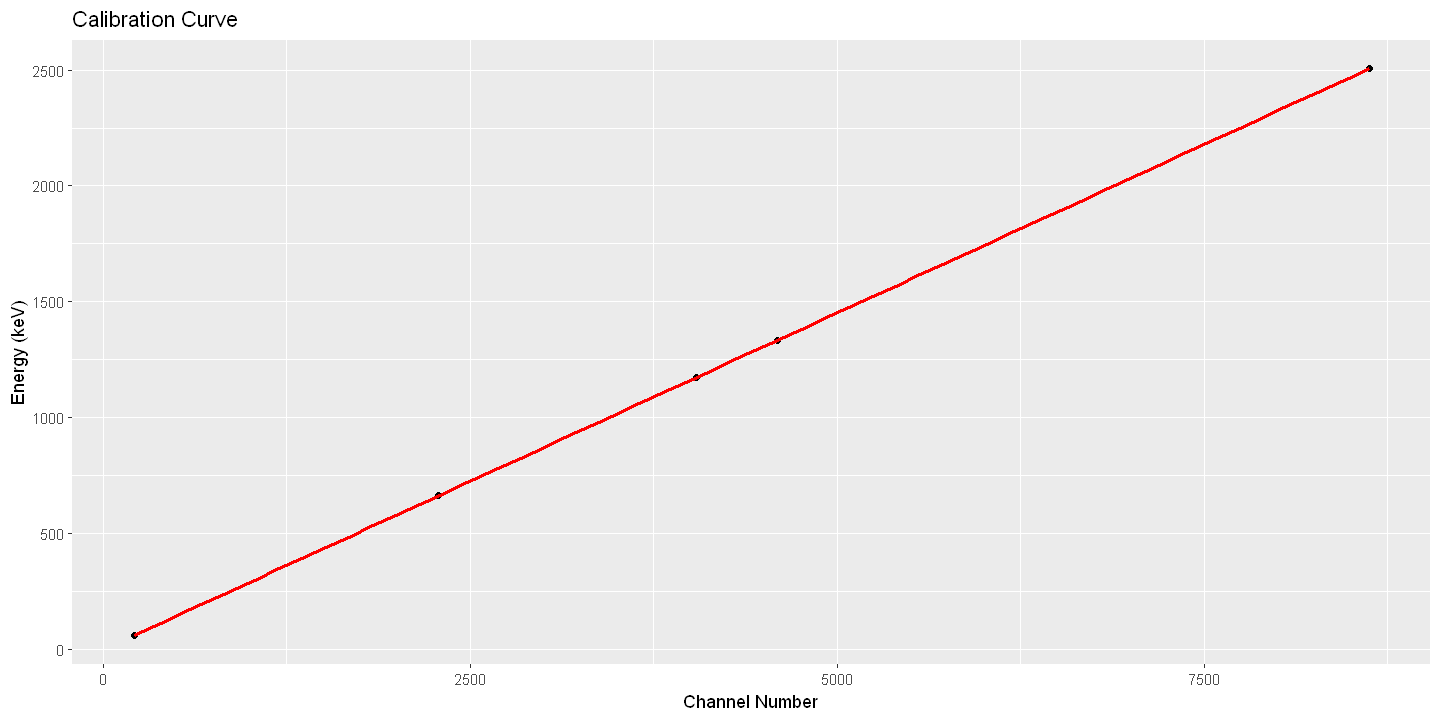

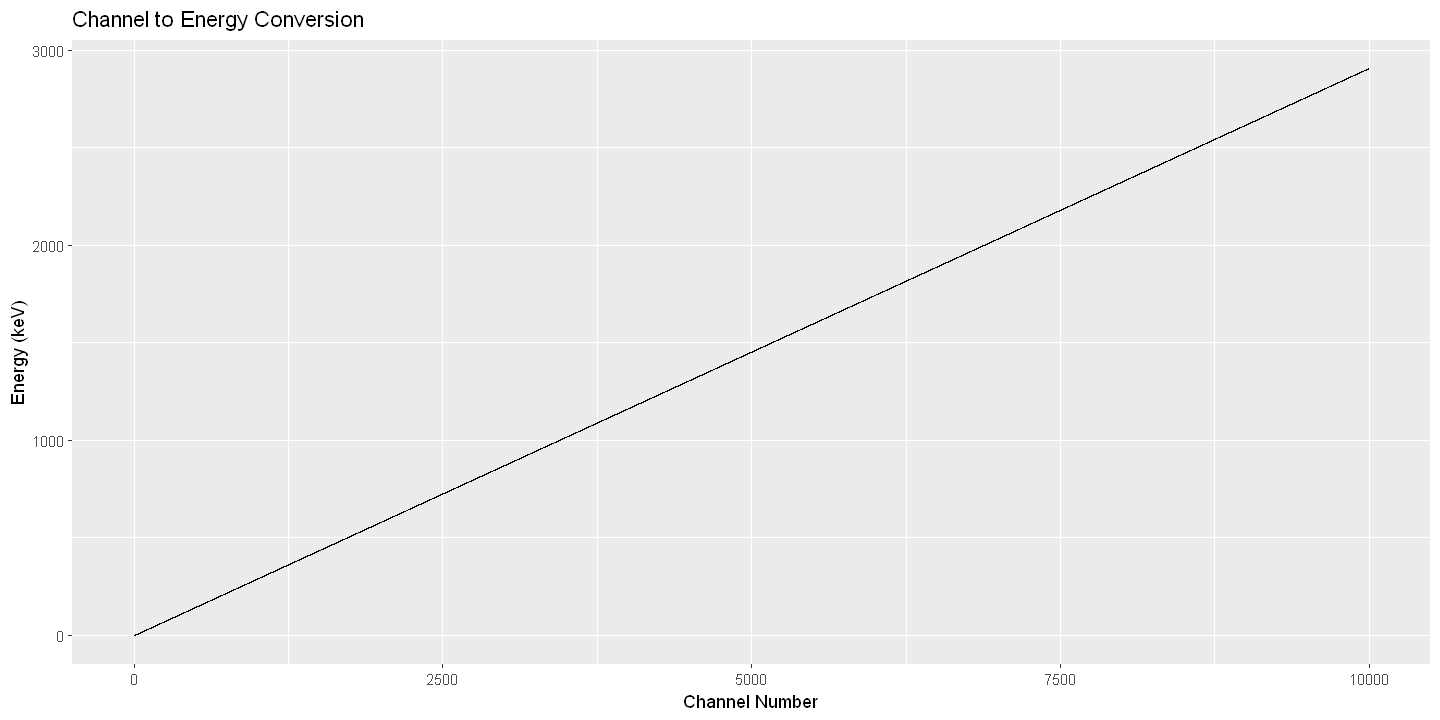

In [25]:
# Given gamma energies (in keV) corresponding to the detected peaks
AmCsCo_energies <- c(59.5409, 661.657, 1173.228, 1332.492, 2505.69)
Th_energies <- c(238.632, 300.089,510.74 , 583.187, 727.330,763.45, 785.37, 860.53,893.408,1078.63,1512.70, 1592.511, 1620.738, 2103.511, 2614.511)

# Corresponding channel positions (excluding the first peak at channel 210)
#AmCsCo_positions <- c(210, 2283, 4043, 4591, 8623) # Essere sicuri che il primo picco corrisponde a quella energia
#LE POSIZIONI SI TROVANO IN:   
#peaks_co60
#peaks_cs137
#peaks_na22
#peaks_AmCsCo
#pekas_Th

# Create a data frame with the positions and corresponding energies
calibration_data <- data.frame(
  Channel = peaks_AmCsCo,
  Energy = AmCsCo_energies
)

# Fit the linear model
calibration_model <- lm(Energy ~ Channel, data = calibration_data)
summary(calibration_model)

# Plot the calibration data and the fitted model
ggplot(calibration_data, aes(x = Channel, y = Energy)) +
  geom_point() +
  geom_smooth(method = "lm", col = "red") +
  ggtitle("Calibration Curve") +
  xlab("Channel Number") +
  ylab("Energy (keV)")

# Define the function to convert channel to energy
channel_to_energy <- function(channel, model) {
  predict(model, newdata = data.frame(Channel = channel))
}

# Test the conversion for a sample channel number
sample_channel <- 5000
predicted_energy <- channel_to_energy(sample_channel, calibration_model)
print(predicted_energy)

# Apply calibration to a range of channels (example: 1 to 10000)
channels <- 1:10000
energies <- channel_to_energy(channels, calibration_model)

# Create a data frame with channels and corresponding energies
calibrated_data <- data.frame(Channel = channels, Energy = energies)

# Plot the calibration result
ggplot(calibrated_data, aes(x = Channel, y = Energy)) +
  geom_line() +
  ggtitle("Channel to Energy Conversion") +
  xlab("Channel Number") +
  ylab("Energy (keV)")


### Step 3: Study Energy Resolution Using MCMC:
Using MCMC methods (with either JAGS or Stan), study the behavior of energy resolution as a function of photon energy.
Infer the parameters of the equations for FWHM and its components.

To study the behavior of the energy resolution as a function of the photon energy and infer the parameters using a Bayesian approach (with either JAGS or Stan), we need to model the Full Width at Half Maximum (FWHM) in terms of the provided equations.

##### Equations
$$ FWHM= \sqrt{(w_d^2+w_e^2)} $$
$$ w_d = 2  \sqrt{(2 \cdot \log(2)) \cdot F \cdot E_{\gamma} \cdot w}​ $$
 
Here, $E_\gamma$ is the photon energy, F is a parameter, and w is a parameter related to the detector.

##### Steps
* Model Definition: Define the Bayesian model using the equations.
* Data Preparation: Prepare the data for MCMC analysis.
* MCMC Simulation: Use Stan to run the MCMC simulation and infer the parameters.
* Result Analysis: Analyze the results to understand the behavior of energy resolution.

#### 1. Model Definition
We need to translate the given equations into a form that can be used with MCMC methods. The parameters to be inferred are $w_e$,F, and w.  

We'll start by rearranging the equations:

* Substitute $w_d$ into the first equation.
##### Stan Model
Let's define a Stan model for the FWHM as a function of photon energy.

In [27]:
# Define the Stan model
stan_model_code <- "
data {
  int<lower=0> N; // number of observations
  vector[N] E_gamma; // photon energy values
  vector[N] FWHM; // FWHM values
}
parameters {
  real<lower=0> F;
  real<lower=0> w;
  real<lower=0> w_e;
}
model {
  vector[N] w_d;
  for (i in 1:N) {
    w_d[i] = 2 * sqrt(2 * log(2) * F * E_gamma[i] * w);
  }
  FWHM ~ normal(sqrt(w_d .* w_d + w_e * w_e), 0.1);
}
"


2. Data Preparation  
We will use the energies and FWHM values from your data. Here are the values you provided earlier:

In [28]:
# Given energies corresponding to the detected peaks
energies <- c(59.5409, 661.657, 1173.228, 1332.492, 2505.69)

# Prepare data for Stan
stan_data <- list(
  N = length(energies),
  E_gamma = energies,
  FWHM = fwhm_values_AmCsCo
)


3. MCMC Simulation  
Compile the Stan model and run the MCMC simulation:

In [29]:
# Compile the model
stan_model <- stan(model_code = stan_model_code,
                   data = stan_data,
                   iter = 2000,
                   chains = 4,
                   control = list(max_treedepth = 10))


# Print the summary of the model
print(stan_model)

Warning message:
"There were 3396 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
https://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded"
Warning message:
"Examine the pairs() plot to diagnose sampling problems
"
Warning message:
"The largest R-hat is 2.56, indicating chains have not mixed.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#r-hat"
Warning message:
"Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#bulk-ess"
Warning message:
"Tail Effective Samples Size (ESS) is too low, indicating posterior variances and tail quantiles may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#tail-ess"


Inference for Stan model: anon_model.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean       se_mean            sd    2.5%     25%          50%
F      6.046750e+29  5.604693e+29  2.109641e+31    0.00    0.00  0.00000e+00
w     2.985631e+100 2.176857e+100 1.142663e+102    0.00    0.01  3.60146e+28
w_e    1.290000e+00  5.000000e-02  1.600000e-01    1.01    1.20  1.28000e+00
lp__  -5.187600e+02  2.000000e-01  1.090000e+00 -521.92 -519.08 -5.18380e+02
              75%         97.5% n_eff Rhat
F     2.33000e+00  4.503078e+19  1417 1.00
w     1.80793e+62  7.207280e+84  2755 1.00
w_e   1.35000e+00  1.680000e+00    12 1.38
lp__ -5.18010e+02 -5.178000e+02    31 1.11

Samples were drawn using NUTS(diag_e) at Fri Jul 12 14:30:45 2024.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


4. Result Analysis  
Extract the results and analyze the parameters:

Estimated parameters:
F: 6.04675e+29 
w: 2.985631e+100 
w_e: 1.28823 


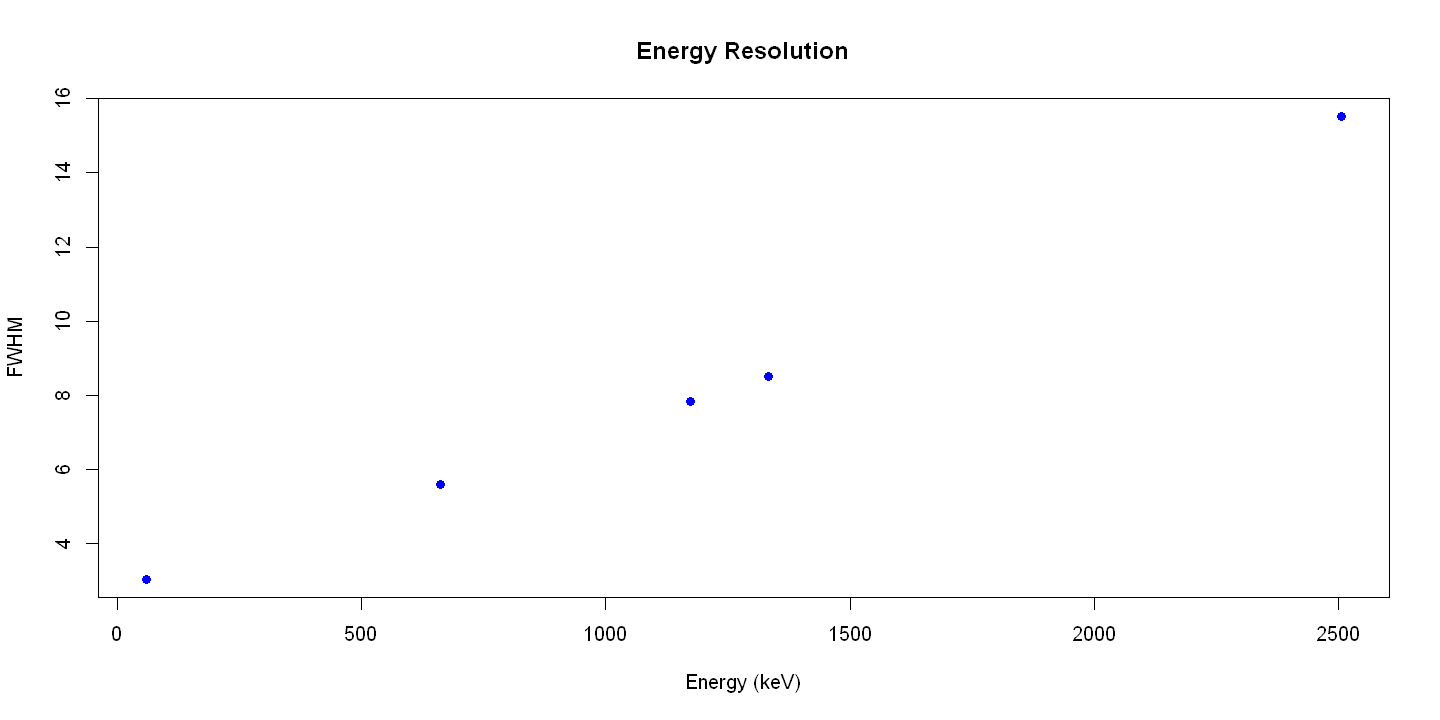

In [31]:
# Extract results
results <- extract(stan_model)

# Get the posterior estimates for the parameters
F_est <- mean(results$F)
w_est <- mean(results$w)
w_e_est <- mean(results$w_e)

# Print the estimated parameters
cat("Estimated parameters:\n")
cat("F:", F_est, "\n")
cat("w:", w_est, "\n")
cat("w_e:", w_e_est, "\n")

# Plot the energy resolution function
energy_range <- seq(min(energies), max(energies), length.out = 100)
w_d <- 2 * sqrt(2 * log(2) * F_est * energy_range * w_est)
predicted_fwhm <- sqrt(w_d^2 + w_e_est^2)

plot(energies, fwhm_values_AmCsCo, pch = 19, col = "blue", xlab = "Energy (keV)", ylab = "FWHM", main = "Energy Resolution")
lines(energy_range, predicted_fwhm, col = "red")
